#PBS2

### Exercise 1

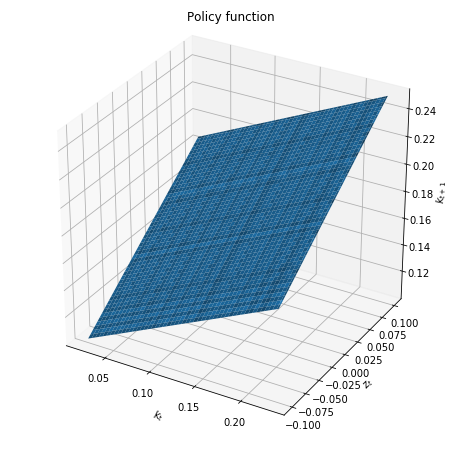

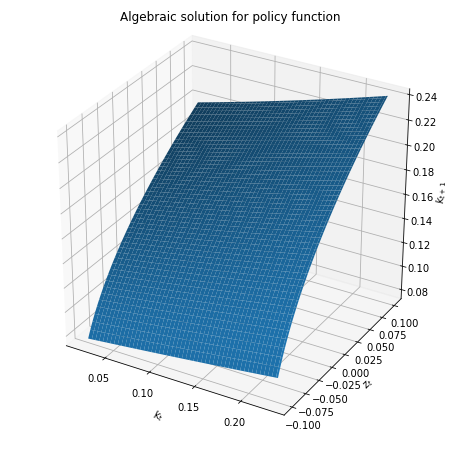

In [2]:
from math import sqrt
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

# define function for linear approximation
def linearcoeff(k, z, alpha, beta, rho):
    A = alpha * beta
    K = A **(1/(1-alpha))
    
    F = (A * K**(alpha-1)) / (K**alpha - K)
    G = - (A * K**(alpha-1) * (alpha + K**(alpha-1))) / (K**alpha - K)
    H = (A*alpha * K**(2*(alpha-1))) / (K**alpha - K)
    L = - (A * K**(2*alpha-1)) / (K**alpha - K)
    M = (A*alpha * K**(2*(alpha-1))) / (K**alpha - K)
    N = rho
    
    P = - (G + sqrt(G*G - 4*F*H)) / (2*F)
    Q = - (L*N + M) / (F*N + F*P + G)
    
    #print(" A=",round(A,4),"\n","K=",round(K,4),"\n","F=",round(F,4),"\n","G=",round(G,4),"\n","H=",round(H,4),"\n",
    #      "L=",round(L,4),"\n","M=",round(M,4),"\n","N=",round(N,4),"\n","P=",round(P,4),"\n","Q=",round(Q,4),"\n")
    return K + P*(k-K) + Q*z

alpha = .4
beta = .98
rho = .9
kbar = (alpha*beta)**(1/(1-alpha))

N = 100
k_grid = np.linspace(.1*kbar,1.1*kbar,N)
z_grid = np.linspace(-.1,.1,N)
k1_mat = np.empty([N,N])

for i in range(N):
    for j in range(N):
        k1_mat[i,j] = linearcoeff(k_grid[i], z_grid[j], alpha, beta, rho)

k,z = np.meshgrid(k_grid,z_grid)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(k, z, k1_mat)
ax.set_xlabel(r"$k_t$")
ax.set_ylabel(r"$z_t$")
ax.set_zlabel(r"$k_{t+1}$")
ax.set_title("Policy function\n")
plt.show()

# Algebraic solution
k1_alg = np.empty([N,N])
for i in range(N):
    for j in range(N):
        k1_alg[i,j] = alpha*beta * np.exp(z_grid[j]) * k_grid[i]**alpha
        
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(k, z, k1_alg)
ax.set_xlabel(r"$k_t$")
ax.set_ylabel(r"$z_t$")
ax.set_zlabel(r"$k_{t+1}$")
ax.set_title("Algebraic solution for policy function\n")
plt.show()

The closer to the steady state and the more accurate is the linear approximation. If you reduce the size of the grid for $k$ and $z$ close to the staedy state, the two graphs are almost the same.

### Exercise 2

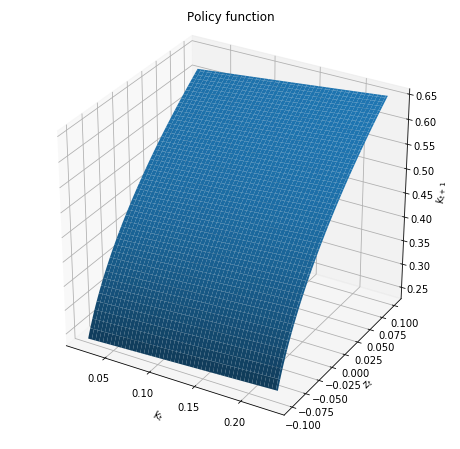

In [3]:
lnk1 = np.empty([N,N])
for i in range(N):
    for j in range(N):
        lnk1[i,j] = np.exp(linearcoeff(np.log(k_grid[i]), z_grid[j], alpha, beta, rho))

k,z = np.meshgrid(k_grid,z_grid)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(k, z, lnk1)
ax.set_xlabel(r"$k_t$")
ax.set_ylabel(r"$z_t$")
ax.set_zlabel(r"$k_{t+1}$")
ax.set_title("Policy function\n")
plt.show()

### Exercise 6

In [4]:
def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Outputs are:
        GDP: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        i: investment
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # truncate labor if necessary
    if ell > 0.9999:
        ell = 0.9999
    elif ell < 0.0001:
        ell = 0.0001
    
    # unpack params
    [alpha, beta, gamma, delta, a, xi, rho, sigma, tau] = params
    
    # find definintion values
    GDP = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*GDP/ell
    r = alpha*GDP/k
    T = tau*(w*ell + (r - delta)*k)
    c = (1-tau)*(w*ell + (r - delta)*k) + k + T - kp
    i = GDP - c
    u = (c**(1-gamma)-1)/(1-gamma) + a * ((1-ell)**(1-xi)-1)/(1-xi)

    return GDP, w, r, T, c, i, u


def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theat0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    # unpack params
    [alpha, beta, gamma, delta, a, xi, rho, sigma, tau] = params
    
    # find definitions for now and next period
    ell = Y
    if ell > 1:
        ell = 0.9999
    elif ell < 0.0001:
        ell = 0.0001
    GDP, w, r, T, c, i, u = Modeldefs(Xp, X, Y, Z, params)
    GDPp, wp, rp, Tp, cp, ip, up = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma)*w*(1-tau)) / (a*(1-ell)**(-xi)) - 1
    E2 = (c**(-gamma)) / (beta*cp**(-gamma)*(1 + (1-tau)*(rp - delta))) - 1
    
    return np.array([E1, E2])

We will be using the `LinApp` toolkit which can be downloaded at `https://github.com/kerkphil/DSGE-Utilities`.  We need to import the functions from that toolkit.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# import the modules from LinApp
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from LinApp_SSL import LinApp_SSL

In [6]:
# set parameter values
alpha = .4
beta = .98
gamma = 2.5
delta = .1
a = .5
xi = 1.5
rho = .9
sigma = np.sqrt(.0004)
tau = .05

# make parameter list to pass to functions
params = np.array([alpha, beta, gamma, delta, a, xi, rho, sigma, tau])

# set LinApp parameters
Zbar = np.array([0.])
nx = 1  # number of X variables
ny = 1  # number of Y variables
nz = 1  # number of Z variables
logX = 0  # 1 if log-linearizing, otherwise 0
Sylv = 0  # just set this to 0 for now.

In [7]:
# take a guess for steady state values of k and ell
guessXY = np.array([.1, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check SS: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
# find the steady state values for the definitions
Ybar, wbar, rbar, Tbar, cbar, ibar, ubar = \
    Modeldefs(kbar, kbar, ellbar, 0., params)

# display all steady state values
print ('kbar:   ', kbar)
print ('ellbar: ', ellbar)
print ('Ybar:   ', Ybar)
print ('wbar:   ', wbar)
print ('rbar:   ', rbar)
print ('Tbar:   ', Tbar)
print ('cbar:   ', cbar)
print ('ibar:   ', ibar)
print ('ubar:   ', ubar)

check SS:  [1.11977316e-10 1.57651669e-13]
kbar:    4.225229026690441
ellbar:  0.579791453152839
Ybar:    1.2832261088024242
wbar:    1.32795276835254
rbar:    0.12148227712120553
Tbar:    0.043035160306669006
cbar:    0.8607032061333797
ibar:    0.42252290266904446
ubar:    -0.7108726381220571


In [8]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM] = \
   LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, RR, SS = LinApp_Solve(AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, NN, Zbar, Sylv)
print ('F: ', FF)
print ('G: ', GG)
print ('H: ', HH)
print ('L: ', LL)
print ('M: ', MM)
print ('N: ', NN)
print ('P: ', PP)
print ('Q: ', QQ)


F:  [[-2.9046017]]
G:  [[5.88766154]]
H:  [[-2.96699916]]
L:  [[2.16849645]]
M:  [[-2.23635645]]
N:  0.9
P:  [[0.91529369]]
Q:  [[0.54504226]]


### Exercise 7

In [9]:
# generate a history of Z's (250 periods)
T = 250
niter = 10000

# Starting values for Linapp_SSL
k0 = np.array([[kbar]])
ell0 = np.array([[ellbar]])

khist = np.zeros([niter,T+1])
ellhist = np.zeros([niter,T+1])
zhist = np.zeros([niter,T+1])
Yhist = np.zeros([niter,T])
whist = np.zeros([niter,T])
rhist = np.zeros([niter,T])
Thist = np.zeros([niter,T])
chist = np.zeros([niter,T])
ihist = np.zeros([niter,T])
uhist = np.zeros([niter,T])

for it in range(niter):
    # generate a history of epsilon shocks with mean zero and variance sigma-squared
    epshist = np.random.randn(1,T+1)*sigma
    # iteratively generate Z's starting with the first value of Z = 0
    for t in range(1,T+1):
        zhist[it,t] = rho*zhist[it,t-1] + epshist[:,t]
    
    # LinApp_SSL requires that Zhist be a 2-dimensional array
    Zhist = np.reshape(zhist[it,:], (T+1, 1))
    # create a history of k's and ell's using LinApp_SSL
    kiter, elliter =  LinApp_SSL(k0, Zhist, XYbar, logX, PP, QQ, RR, SS)
    khist[it,:] = kiter.transpose()
    ellhist[it,:] = elliter.transpose()
    
    for t in range(T):
        Yhist[it,t], whist[it,t], rhist[it,t], Thist[it,t], chist[it,t], ihist[it,t], uhist[it,t] = \
            Modeldefs(khist[it,t+1], khist[it,t], ellhist[it,t], zhist[it,t], params)

# delete last observation
khist = khist[:,0:T]
zhist = zhist[:,0:T]
ellhist = ellhist[:,0:T]

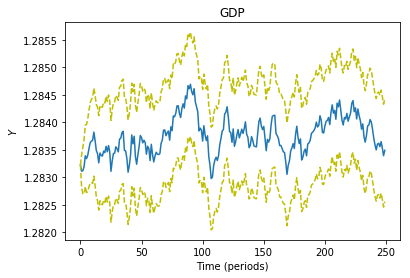

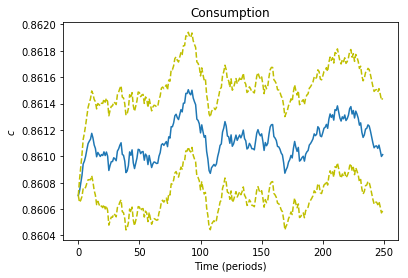

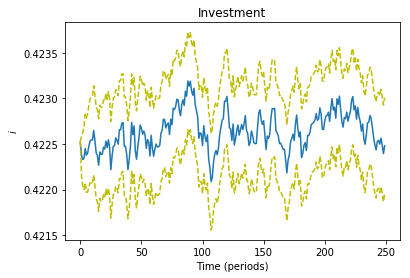

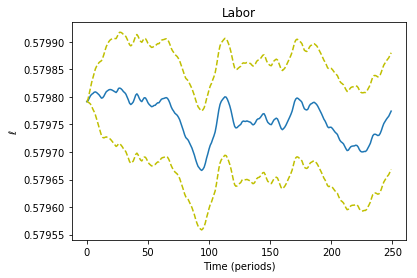

In [11]:
# compute the average for GDP, consumption, investment, labor
Ymean = np.mean(Yhist, axis = 0)
cmean = np.mean(chist, axis = 0)
imean = np.mean(ihist, axis = 0)
ellmean = np.mean(ellhist, axis = 0)

# confidence intervals
Ystd = np.std(Yhist, axis = 0)
Yupper = Ymean + 1.96*Ystd/np.sqrt(niter)
Ylower = Ymean - 1.96*Ystd/np.sqrt(niter)
cstd = np.std(chist, axis = 0)
cupper = cmean + 1.96*cstd/np.sqrt(niter)
clower = cmean - 1.96*cstd/np.sqrt(niter)
istd = np.std(ihist, axis = 0)
iupper = imean + 1.96*istd/np.sqrt(niter)
ilower = imean - 1.96*istd/np.sqrt(niter)
ellstd = np.std(ellhist, axis = 0)
ellupper = ellmean + 1.96*ellstd/np.sqrt(niter)
elllower = ellmean - 1.96*ellstd/np.sqrt(niter)

# plot GDP
plt.plot(range(T), Ymean, '-')
plt.plot(range(T), Yupper, 'y--')
plt.plot(range(T), Ylower, 'y--')
plt.xlabel("Time (periods)")
plt.ylabel(r"$Y$")
plt.title("GDP")
plt.show()

# plot consumption
plt.plot(range(T), cmean, '-')
plt.plot(range(T), cupper, 'y--')
plt.plot(range(T), clower, 'y--')
plt.xlabel("Time (periods)")
plt.ylabel(r"$c$")
plt.title("Consumption")
plt.show()

# plot consumption
plt.plot(range(T), imean, '-')
plt.plot(range(T), iupper, 'y--')
plt.plot(range(T), ilower, 'y--')
plt.xlabel("Time (periods)")
plt.ylabel(r"$i$")
plt.title("Investment")
plt.show()

# plot consumption
plt.plot(range(T), ellmean, '-')
plt.plot(range(T), ellupper, 'y--')
plt.plot(range(T), elllower, 'y--')
plt.xlabel("Time (periods)")
plt.ylabel(r"$\ell$")
plt.title("Labor")
plt.show()

### Exercise 8

In [23]:
series = [Yhist, chist, ihist, ellhist]
seriesnames = ['GDP', 'Consumption', 'Investment', 'Labor']
S = len(series)

means = np.empty((niter,S))
volat = np.empty((niter,S))
coeffvar = np.empty((niter,S))
relvol = np.empty((niter,S))
autocorr = np.empty((niter,S))
cyclic = np.empty((niter,S))

for i, s in enumerate(series):
    # compute moments
    means[:,i] = np.mean(s, axis=1)
    volat[:,i] = np.std(s, axis=1)
    coeffvar[:,i] = means[:,i] / volat[:,i]
    relvol[:,i] = volat[:,i] / volat[:,i]
    for j in range(1,niter):
        autocorr[j,i] = np.corrcoef(s[j,:-1], s[j,1:])[0,1]
        cyclic[j,i] = np.corrcoef(s[j,:], Yhist[j,:])[0,1]
    
    # print results
    print(seriesnames[i], "\n")
    print("{:<25}{:<10}{:<10}".format('','Average','Std Err'))
    print("-"*45)
    print("{:<25}{:<10}{:<10}".format('Mean',round(np.mean(means[:,i]),4),round(np.std(means[:,i]),4)))
    print("{:<25}{:<10}{:<10}".format('Volatility',round(np.mean(volat[:,i]),4),round(np.std(volat[:,i]),4)))
    print("{:<25}{:<10}{:<10}".format('Coeff Var',round(np.mean(coeffvar[:,i]),4),round(np.std(coeffvar[:,i]),4)))
    print("{:<25}{:<10}{:<10}".format('Rel volatility',round(np.mean(relvol[:,i]),4),round(np.std(relvol[:,i]),4)))
    print("{:<25}{:<10}{:<10}".format('Persistence',round(np.mean(autocorr[:,i]),4),round(np.std(autocorr[:,i]),4)))
    print("{:<25}{:<10}{:<10}".format('Cyclicality',round(np.mean(cyclic[:,i]),4),round(np.std(cyclic[:,i]),4)))
    print("_"*45, "\n")
    



GDP 

                         Average   Std Err   
---------------------------------------------
Mean                     1.2838    0.0159    
Volatility               0.0436    0.0077    
Coeff Var                30.3557   5.3626    
Rel volatility           1.0       0.0       
Persistence              0.9318    0.0257    
Cyclicality              0.9999    0.01      
_____________________________________________ 

Consumption 

                         Average   Std Err   
---------------------------------------------
Mean                     0.8611    0.0081    
Volatility               0.0194    0.0041    
Coeff Var                46.3226   9.9467    
Rel volatility           1.0       0.0       
Persistence              0.9703    0.0158    
Cyclicality              0.9663    0.0123    
_____________________________________________ 

Investment 

                         Average   Std Err   
---------------------------------------------
Mean                     0.4226    0.0078  

### Exercise 9

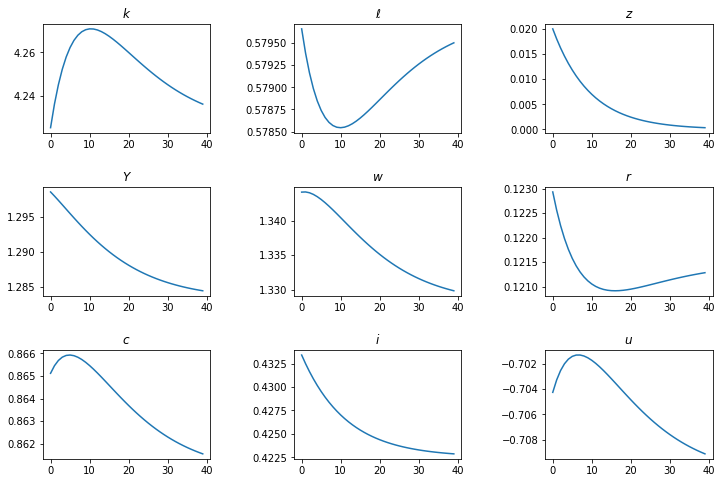

In [24]:
# set number of observations
nobs = 40 

# create a history of z's using equation
zhist = np.zeros(nobs+1)
#epshist = sigma*np.random.normal(0., 1., nobs+1)
epshist = np.zeros(nobs+1)
epshist[0] = sigma
zhist[0] = epshist[0]
for t in range(1,nobs+1):
    zhist[t] = rho*zhist[t-1] + epshist[t]
    
# LinApp_SSL requires that Zhist be a 2-dimensional array
Zhist = np.reshape(zhist, (nobs+1, 1))

# Linapp_SSL also requires that starting values be arrays
k0 = np.array([[kbar]])
ell0 = np.array([[ellbar]])

# create a history of k's and ell's using LinApp_SSL
khist, ellhist =  LinApp_SSL(k0, Zhist ,XYbar, logX, PP, QQ, RR, SS)

# create histories of remaining variables
Yhist = np.zeros(nobs)
whist = np.zeros(nobs)
rhist = np.zeros(nobs)
Thist = np.zeros(nobs)
chist = np.zeros(nobs)
ihist = np.zeros(nobs)
uhist = np.zeros(nobs)
for t in range(0,nobs):
    Yhist[t], whist[t], rhist[t], Thist[t], chist[t], ihist[t], uhist[t] = \
        Modeldefs(khist[t+1], khist[t], ellhist[t], zhist[t], params)
        
# delete last observation
khist = khist[0:nobs]
zhist = zhist[0:nobs]
ellhist = ellhist[0:nobs]

# plot time series
time = range(0, nobs)

fig = plt.figure(figsize=(12,8))
plt.subplot(3,3,1)
plt.subplots_adjust(hspace = .5)
plt.subplots_adjust(wspace = .5)
plt.plot(time, khist, label=r'$k$')
plt.title(r'$k$')
plt.subplot(3,3,2)
plt.plot(time, ellhist, label=r'$\ell$')
plt.title(r'$\ell$')
plt.subplot(3,3,3)
plt.plot(time, zhist, label=r'$z$')
plt.title(r'$z$')
plt.subplot(3,3,4)
plt.plot(time, Yhist, label=r'$Y$')
plt.title(r'$Y$')
plt.subplot(3,3,5)
plt.plot(time, whist, label=r'$w$')
plt.title(r'$w$')
plt.subplot(3,3,6)
plt.plot(time, rhist, label=r'$r$')
plt.title(r'$r$')
plt.subplot(3,3,7)
plt.plot(time, chist, label=r'$c$')
plt.title(r'$c$')
plt.subplot(3,3,8)
plt.plot(time, ihist, label=r'$i$')
plt.title(r'$i$')
plt.subplot(3,3,9)
plt.plot(time, uhist, label=r'$u$')
plt.title(r'$u$')
plt.show()